In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import dLdp
from utils.regions import CircleExterior
from tracking_log import logger

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

## System Communication Schema


![System Communication Schema](Schema.png)


## Main Loop 

In [2]:
from utils.regions import Rect2D




In [3]:
def main(n_sensors,std,boundary_radius):
    # Set up mobile sensors and sources
    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    
    
    initial_locs = random_initial_poses(n_sensors,xmin=0,xmax=3,ymin=0,ymax=3)
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]
    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)
    initial_guess = np.array([4.,2.])
    xlim = (-np.inf,np.inf)
    ylim = (-np.inf,np.inf)

    estimator = getDynamicFilter(len(mobile_sensors),len(source),C1s,C0s,ks,bs,initial_guess,filterType="ekf",xlim=xlim,ylim=ylim)
    estimator_name = 'ekf'


    # Set up waypoint planner
    f_dLdp=dLdp(C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    planning_timesteps = 1
    max_linear_speed = 0.22
    planning_dt = 1
    epsilon = 0.1
    # The FIM waypoint planning  
    fplan = lambda qs,ps:FIM_ascent_path_planning(f_dLdp,qs,ps,n_sen,\
                    planning_timesteps,\
                    max_linear_speed,\
                    planning_dt,\
                    epsilon,\
                    # Rect2D(self.xlim,self.ylim))
                    CircleExterior(np.array([6,6]),boundary_radius))

    # Set up data logger
    log = logger(sensor_names,src_names)

    # Enter main loop

    N = 40
    for _ in range(N):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)

        # Estimate
        qhat = estimator.update_and_estimate_loc(ps,y)


         # Record
        for s in source:
            log.est_locs_log[estimator_name].append(qhat)
            log.src_locs[s.name].append(s.loc)

        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)


        #Plan 
        waypoints = fplan(qhat,ps)

        # Move
        for i in range(n_sen):
            mobile_sensors[i].update_loc(waypoints[0][i])
    return log
def get_err(log):
    for key,est_locs in log['est_locs_log'].items():
        if key in["ekf"]:            
            target_locs = log['src_locs']['source_1']
            l = np.min([len(target_locs),len(est_locs)])
            target_locs = target_locs[:l]
            est_locs = est_locs[:l]
            target_locs = target_locs[~(np.isnan(est_locs))].reshape(-1,2)
            est_locs = est_locs[~(np.isnan(est_locs))].reshape(-1,2)
            
            if len(est_locs)>0:
                err = np.linalg.norm(est_locs-target_locs,axis = 1)
                return err

def random_initial_poses(n_sensors,xmin,xmax,ymin,ymax):
    sensor_poses = np.zeros((n_sensors,2))
    sensor_poses[:,0]= xmin + np.random.rand(n_sensors)*(xmax-xmin)
    sensor_poses[:,1]= ymin + np.random.rand(n_sensors)*(ymax-ymin)
    return sensor_poses

In [41]:
Ns =[3,10,20,50]
errs = {}
noise_std = 0.01
N_trails= 100
boundary_r = 0

for n_sensor in Ns:
    print("n_sensor = {}".format(n_sensor))
    errs[n_sensor] = []
    for _ in range(N_trails):
    #     print("Start main loop")
        print("{}/{} finished".format(_,N_trails))
        log = main(n_sensor,noise_std)
    #     print("Start export")
        record = log.export()
    #     print("Start Append")
        errs[n_sensor].append(get_err(record))

n_sensor = 3
0/100 finished
1/100 finished
2/100 finished
3/100 finished
4/100 finished
5/100 finished
6/100 finished
7/100 finished
8/100 finished
9/100 finished
10/100 finished
11/100 finished
12/100 finished
13/100 finished
14/100 finished
15/100 finished
16/100 finished
17/100 finished
18/100 finished
19/100 finished
20/100 finished
21/100 finished
22/100 finished
23/100 finished
24/100 finished
25/100 finished
26/100 finished
27/100 finished
28/100 finished
29/100 finished
30/100 finished
31/100 finished
32/100 finished
33/100 finished
34/100 finished
35/100 finished
36/100 finished
37/100 finished
38/100 finished
39/100 finished
40/100 finished
41/100 finished
42/100 finished
43/100 finished
44/100 finished
45/100 finished
46/100 finished
47/100 finished
48/100 finished
49/100 finished
50/100 finished
51/100 finished
52/100 finished
53/100 finished
54/100 finished
55/100 finished
56/100 finished
57/100 finished
58/100 finished
59/100 finished
60/100 finished
61/100 finished
62/10

In [42]:

filepath = "MovingSensorStaticTargetNoise{}_Free.pkl".format(noise_std)
with open(filepath,'wb') as file:
    pkl.dump(errs,file)

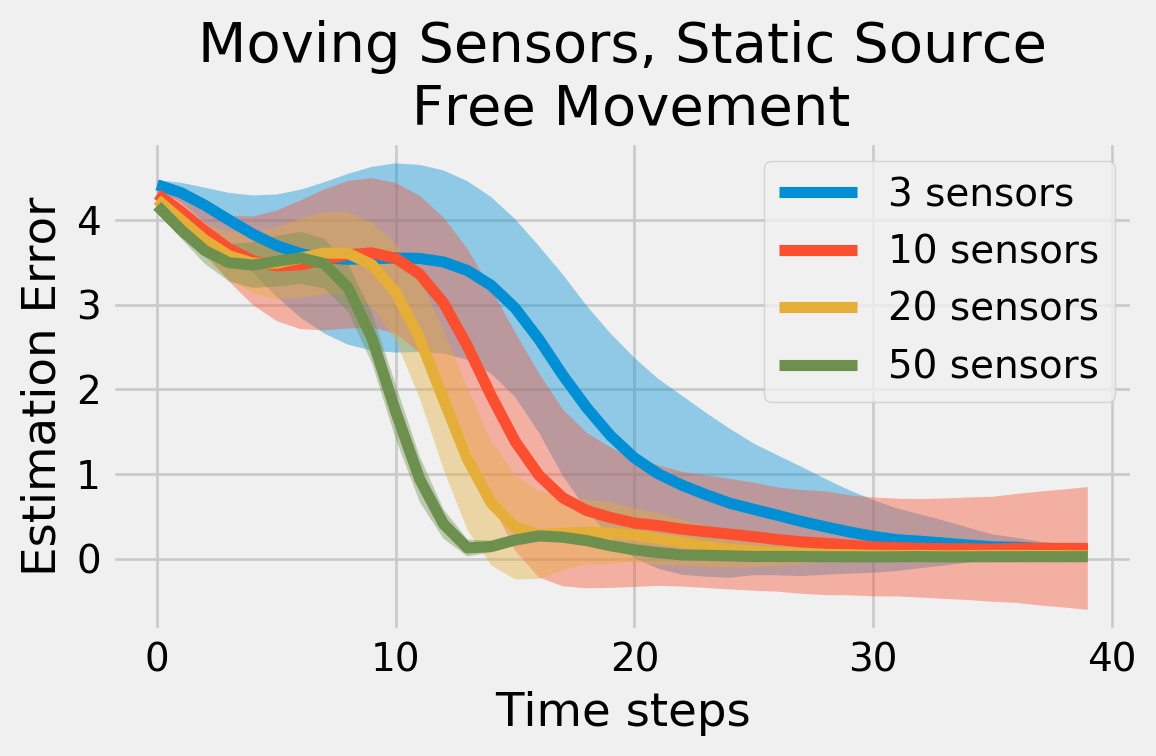

In [43]:
plt.figure(dpi=200)
for n,err in errs.items():
    mse = np.mean(err,axis=0)
    std = np.std(err,axis=0)
    x = range(len(mse))
    plt.plot(x, mse,label='{} sensors'.format(n))
    plt.fill_between(x, mse-std, mse+std,alpha=0.4)
plt.title("Moving Sensors, Static Source\n Free Movement")
plt.xlabel("Time steps")
plt.ylabel("Estimation Error")
plt.legend()
plt.tight_layout()
plt.savefig("MovingSensorStaticSourceNoise{}_Free.png".format(noise_std))
plt.show()